# Supermarket Sales: Global Explanations

Shenyue jia

## Data Information

- The salary data for data scientist is collected and prepared by [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/).

### Data Dictionary

Variable Name  | Description
-------------------|------------------
Item_Identifier	| Unique product ID
Item_Weight	| Weight of product
Item_Fat_Content	| Whether the product is low fat or regular
Item_Visibility	| The percentage of total display area of all products in a store allocated to the particular product
Item_Type	| The category to which the product belongs
Item_MRP	| Maximum Retail Price (list price) of the product
Outlet_Identifier	| Unique store ID
Outlet_Establishment_Year	| The year in which store was established
Outlet_Size	| The size of the store in terms of ground area covered
Outlet_Location_Type	| The type of area in which the store is located
Outlet_Type	| Whether the outlet is a grocery store or some sort of supermarket
Item_Outlet_Sales	| Sales of the product in the particular store. This is the target variable to be predicted.

## Analysis preparation

### Imports

In [2]:
# data wrangling
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import shap
shap.initjs()
from lime.lime_tabular import LimeTabularExplainer

# machine learning
import joblib

### Visualization setup

In [3]:
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

### Set random state for reproducibility

In [4]:
SEED = 321
np.random.seed(SEED)

### Load model

- Previously, we saved a `DecisionTreeRegressor` model

In [5]:
# load model from pre-saved joblib file
loaded_joblib = joblib.load('best-models.joblib')
loaded_joblib.keys()

dict_keys(['preprocessor', 'X_train', 'y_train', 'X_test', 'y_test', 'LinearRegression', 'DecisionTreeRegressor'])

In [6]:
# save parameters to variables
preprocessor = loaded_joblib['preprocessor']
X_train = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']
LinearRegression = loaded_joblib['LinearRegression']
DecisionTreeRegressor = loaded_joblib['DecisionTreeRegressor']

## Explain the tree-based model with `SHAP`

### Create an `X_shap` and `y_shap` variable from the training data

In [7]:
# sample a subset of the data
X_shap = shap.sample(X_train, nsamples = 500, random_state = SEED)

In [8]:
# use the index of X_shap to slice out the corresponding y data 
y_shap = y_train.loc[X_shap.index]

### Create a model explainer

In [9]:
explainer = shap.Explainer(DecisionTreeRegressor)
explainer

### Calculate the shap values for the model

In [10]:
# assemble a model explainer with X_shap and y_shap
shap_values = explainer(X_shap, y_shap)
shap_values.shape

(500, 42)

In [11]:
# get dimension of X_shap
X_shap.shape

(500, 42)

- The dimension of shap values is the same as X data

### Create a summary plot with `plot_type = 'bar'`

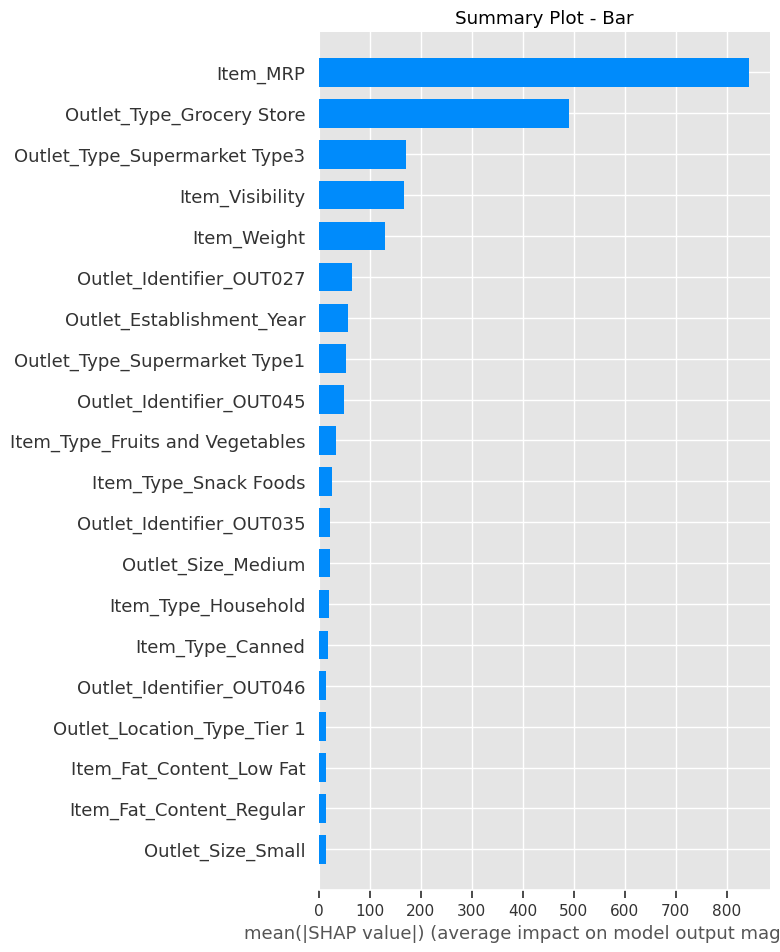

In [12]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_shap, plot_type = 'bar', show = False)
ax.set_title('Summary Plot - Bar');
fig.savefig('PNG/Summary_Plot_Bar.png')

- In previous analysis, we excluded features derived from `Outlet_Identifier` as they are the IDs of outlets
- The features displayed below do not include any features derived from `Outlet_Identifier`
- We can see the top 5 most important features derived from the model and by SHAP are slightly different (in orders)
    - `Item_Visibility` ranked #3 in the result from model, but ranked #4 in results by SHAP
    - `Item_Visibility` ranked #4 in the result from model, but ranked #5 in results by SHAP
    - `Outlet_Type_Supermarket Type3` ranked #5 in the result from model, but ranked #3 in results by SHAP

Rank | Model | SHAP
-----| -----| ----
1 | `Item_MRP`| `Item_MRP`
2 | `Outlet_Type_Grocery Store` | `Outlet_Type_Grocery Store`
3 | `Item_Visibility` | `Outlet_Type Supermarket Type3`
4 | `Item_Weight` | `Item_Visibility`
5 | `Outlet_Type_Supermarket Type3` | `Item_Weight`

### Create a second summary plot - with `plot_type='dot'`

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


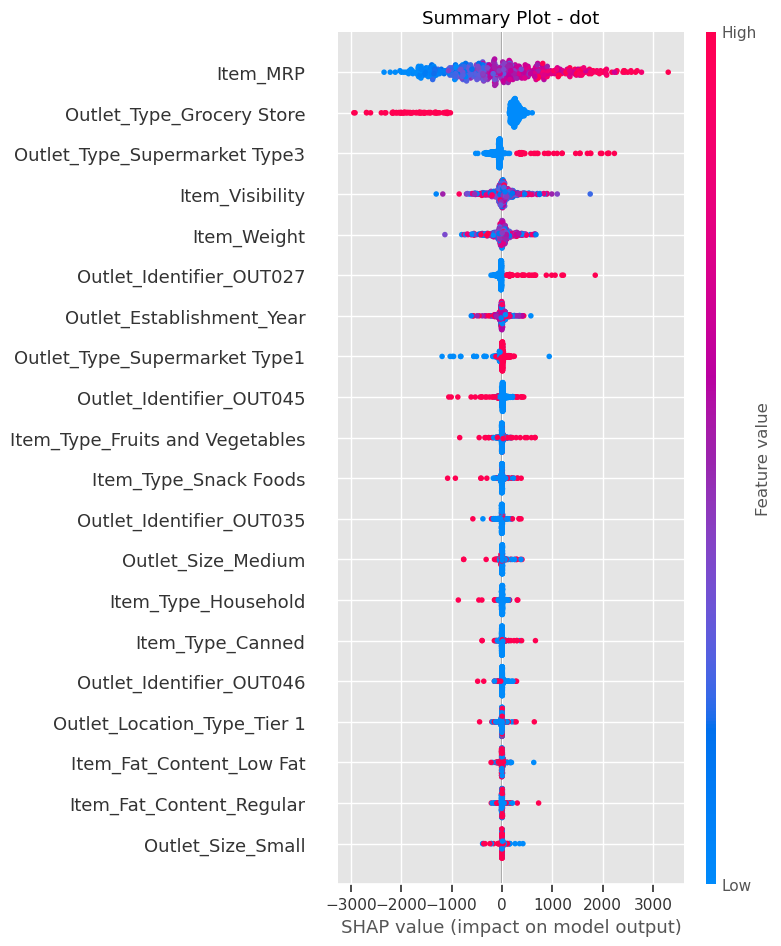

In [13]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_shap, show = False)
ax.set_title('Summary Plot - dot');
fig.savefig('PNG/Summary_Plot_dot.png')

- The Top 3 most important features according to SHAP are `Item_MRP`, `Outlet_Type_Grocery Store`, and `Outlet_Type Supermarket Type3`
    - `Item_MRP`
        - Positive values (red dots on the right). The greater the maximum retail price of an item, the higher the model will predict as the item outlet sales.
        - Negative values (blue dots on the left). The smaller the maximum retail price of an item, the lower the model will predict as the item outlet sales.
    - `Outlet_Type_Grocery Store`
        - Positive values (red dots on the left). If items are more likely to be sold in Grocery Store, it tend to have a lower value in sales.
        - Negative values (blue dots on the right). If items are less likely to be sold in Grocery Store, it tend to have a higher value in sales.
    - `Outlet_Type Supermarket Type3`
        - Positive values (red dots on the right). If items are more likely to be sold in Type3 Supermarket, it tend to have a higher value in sales.
        - Negative values (blue dots on the left). If items are less likely to be sold in Type3 Supermarket, it tend to have a lower value.

### Global Force Plot

In [25]:
## Global Force Plot 
shap.force_plot(explainer.expected_value, shap_values.values, features=X_shap)

# Supermarket Sales: Local Explanations

## Select max of `Item_MRP`

- We can inspect the maximum retail price (`Item_MRP`) record to inspect as it is the most important feature according to both model results and `SHAP` visualization

In [14]:
# set a new index to match shap values
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)

In [15]:
# select the row with highest maximum retail price
index_max_mrp = X_shap_local['Item_MRP'].idxmax()

In [16]:
# check the feature values for selected example
X_shap_local.iloc[index_max_mrp]

Item_Weight                          10.000000
Item_Visibility                       0.025932
Item_MRP                            264.722600
Outlet_Establishment_Year          2009.000000
Item_Fat_Content_Low Fat              1.000000
Item_Fat_Content_Regular              0.000000
Item_Type_Baking Goods                0.000000
Item_Type_Breads                      0.000000
Item_Type_Breakfast                   0.000000
Item_Type_Canned                      1.000000
Item_Type_Dairy                       0.000000
Item_Type_Frozen Foods                0.000000
Item_Type_Fruits and Vegetables       0.000000
Item_Type_Hard Drinks                 0.000000
Item_Type_Health and Hygiene          0.000000
Item_Type_Household                   0.000000
Item_Type_Meat                        0.000000
Item_Type_Others                      0.000000
Item_Type_Seafood                     0.000000
Item_Type_Snack Foods                 0.000000
Item_Type_Soft Drinks                 0.000000
Item_Type_Sta

In [17]:
# what was the actual item outlet sale?
y_shap_local.iloc[index_max_mrp]

3171.8712

### Lime tabular explanation

In [18]:
# Create a lime explainer with X_shap_local with regression as the mode
lime_explainer = LimeTabularExplainer(training_data = X_shap_local.values, feature_names = X_shap_local.columns, mode = 'regression')
lime_explainer

In [19]:
# Use the lime explainer to explain the maximum retail price
exp = lime_explainer.explain_instance(X_shap_local.loc[index_max_mrp], DecisionTreeRegressor.predict)
exp.show_in_notebook()

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


### Interpretation of LIME table

- This item had a predicted outlet sales value of 3171.87.
- The following features are associated with **high** outlet sales value:
    - `Outlet_Type` **IS NOT** `Grocery Store`
    - `Item_MRP` = 264.72 (> 179.52)
    - `Item_Type` **IS NOT** `Others`

- The following features are associated with **low** outlet sales value:
    - `Outlet_Type_Supermarket` **IS NOT** `Type3`
    - `Item_Type` **IS NOT** `Breakfast`
    - `Outlet_Identifier` **IS NOT** `Out027`
    - `Item_Type` **IS NOT** `Soft Drinks`, `Seafood`, or `Fruis and Vegetables`
    - If we flip the above conditions, they are conditions associated with high outlet sales value

In [20]:
# get the explanation values as a list
exp_df = pd.DataFrame(exp.as_list(), columns = ['Effect', 'Value'])
exp_df

Effect        Value
0        Outlet_Type_Grocery Store <= 0.00  1980.352805
1                        Item_MRP > 179.52  1669.270771
2    Outlet_Type_Supermarket Type3 <= 0.00  -713.571694
3              Item_Type_Breakfast <= 0.00  -427.667454
4         Outlet_Identifier_OUT027 <= 0.00  -321.330595
5                 Item_Type_Others <= 0.00   231.471955
6            Item_Type_Soft Drinks <= 0.00  -169.292910
7                Item_Type_Seafood <= 0.00  -158.753797
8  Item_Type_Fruits and Vegetables <= 0.00  -151.894091
9           Item_Type_Baking Goods <= 0.00  -141.152762

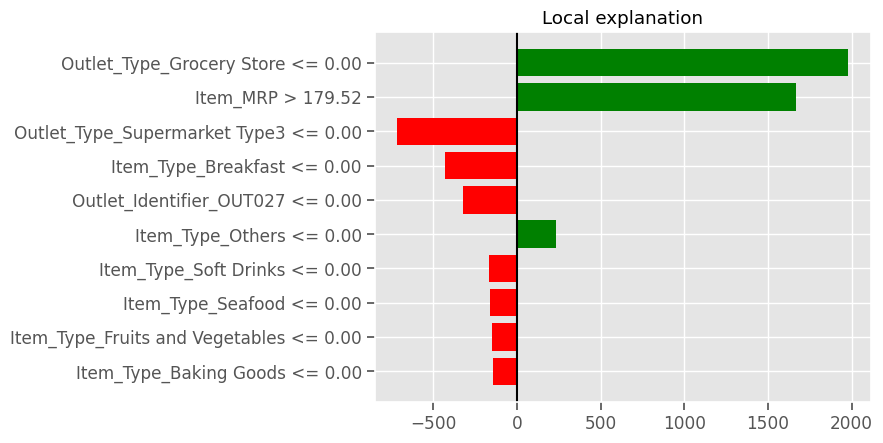

In [22]:
# get the explanation barplot as a matplotlib figure
fig = exp.as_pyplot_figure();
axes = fig.get_axes()
axes[0].axvline(0, color = 'k');
fig.savefig('PNG/Lime-Explanation-Highest-MRP.png')

### Individual Force Plot

In [26]:
# show the record with the maximum Item_MRP
shap.force_plot(explainer.expected_value, 
                shap_values = shap_values[index_max_mrp].values, 
                features = X_shap_local.iloc[index_max_mrp])

In [56]:
## plotting example force plot for most inf.deaths (from linreg)
force_plot = shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[index_max_vis].values,
               features=X_shap_local.iloc[index_max_vis],
                             # ADD matplotlib=True and show=False
                             matplotlib=True, show=False)
force_plot.tight_layout()
plt.savefig('PNG/indivisual-force-plot-max-mrp.png', bbox_inches='tight')

### Interpretation of Indivisual Force Plot

- The base value is 2154
- `SHAP` value (f(x)) is 3171.87
- `Item_MRP` is the most important feature for this item
- `Item_MRP` is pushing the prediction toward a higher value (red bar). The `Item_MRP` for this item is 264.7.
- `Outlet_Type` (not Grocery Store) AND `Item_Visibility` (0.02593) are also pushing the prediction toward a higher value.
- `Outlet_Type_Supermarket` (Type1) and `Item_Type` (Frozen Food) are pushing prediction toward a lower value 

## Select max of `Item_Visibility`


- We can inspect the maximum retail price (`Item_Visibility`) record to inspect as it is also an  important numeric feature according to both model results and `SHAP` visualization

In [27]:
# select the row with the highest item visibility
index_max_vis = X_shap_local['Item_Visibility'].idxmax()

In [28]:
# check the feature values for selected example
X_shap_local.iloc[index_max_vis]

Item_Weight                          13.380000
Item_Visibility                       0.293418
Item_MRP                            194.613600
Outlet_Establishment_Year          1985.000000
Item_Fat_Content_Low Fat              1.000000
Item_Fat_Content_Regular              0.000000
Item_Type_Baking Goods                0.000000
Item_Type_Breads                      0.000000
Item_Type_Breakfast                   0.000000
Item_Type_Canned                      0.000000
Item_Type_Dairy                       0.000000
Item_Type_Frozen Foods                0.000000
Item_Type_Fruits and Vegetables       0.000000
Item_Type_Hard Drinks                 0.000000
Item_Type_Health and Hygiene          0.000000
Item_Type_Household                   1.000000
Item_Type_Meat                        0.000000
Item_Type_Others                      0.000000
Item_Type_Seafood                     0.000000
Item_Type_Snack Foods                 0.000000
Item_Type_Soft Drinks                 0.000000
Item_Type_Sta

In [29]:
# what was the actual item outlet sale?
y_shap_local.iloc[index_max_vis]

583.2408

### LIME Tabular Explanation

In [30]:
# Create a lime explainer with X_shap_local with regression as the mode
lime_explainer = LimeTabularExplainer(training_data = X_shap_local.values, feature_names = X_shap_local.columns, mode = 'regression')
lime_explainer

In [31]:
# Use the lime explainer to explain the maximum of item visibility
exp = lime_explainer.explain_instance(X_shap_local.loc[index_max_vis], DecisionTreeRegressor.predict)
exp.show_in_notebook()

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


### Interpretation of LIME table

- This item had a predicted outlet sales value of 583.24.
- The following features are associated with **high** outlet sales value:
    - `Item_MRP` = 264.72 (> 179.52)
    - `Item_Type` **IS NOT** `Breakfast`
    - `Outlet_Size` **IS NOT** `High`

- The following features are associated with **low** outlet sales value:
    - `Outlet_Type` **IS NOT** `Grocery Store`
    - `Outlet_Type_Supermarket` **IS NOT** `Type3`
    - `Item_Type` **IS NOT** `Seafood`, `Soft Drinks`, or `Others`
    - `Outlet_Identifier` **IS NOT** `OUT027`
    - If we flip the above conditions, they are conditions associated with high outlet sales value

In [32]:
# get the explanation values as a list
exp_df = pd.DataFrame(exp.as_list(), columns = ['Effect', 'Value'])
exp_df

Effect        Value
0       Outlet_Type_Grocery Store > 0.00 -2101.196863
1                      Item_MRP > 179.52  1717.653792
2  Outlet_Type_Supermarket Type3 <= 0.00  -988.097940
3              Item_Type_Seafood <= 0.00  -837.400586
4       Outlet_Identifier_OUT027 <= 0.00  -208.819867
5            Item_Type_Breakfast <= 0.00   185.311227
6          Item_Type_Soft Drinks <= 0.00  -150.924297
7               Item_Type_Others <= 0.00  -129.619714
8               Outlet_Size_High <= 0.00   113.785267
9                 Item_Type_Meat <= 0.00    96.767091

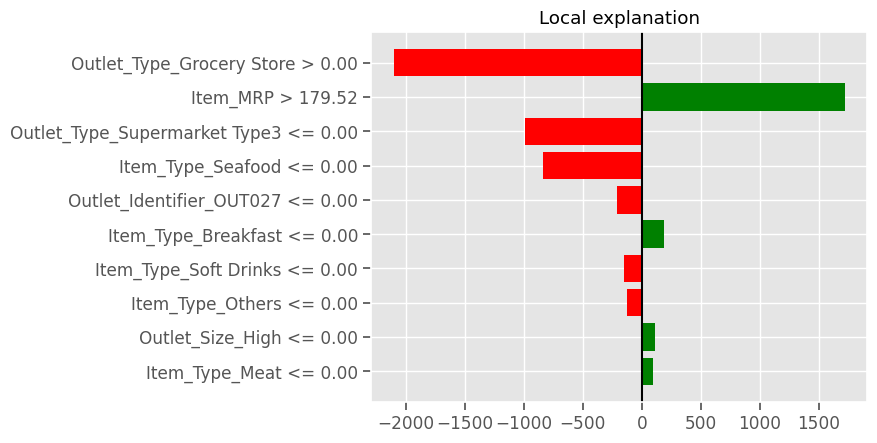

In [33]:
# get the explanation barplot as a matplotlib figure
fig = exp.as_pyplot_figure();
axes = fig.get_axes()
axes[0].axvline(0, color = 'k');
fig.savefig('PNG/Lime-Explanation-Highest-Visibility.png')

### Individual Force Plot

In [57]:
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[index_max_vis].values,
               features=X_shap_local.iloc[index_max_vis])

In [58]:
## plotting example force plot for most inf.deaths (from linreg)
force_plot = shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[index_max_vis].values,
               features=X_shap_local.iloc[index_max_vis],
                             # ADD matplotlib=True and show=False
                             matplotlib=True, show=False)
force_plot.tight_layout()
plt.savefig('PNG/indivisual-force-plot-max-vis.png', bbox_inches='tight')

### Interpretation of Indivisual Force Plot

- The base value is 2154
- `SHAP` value (f(x)) is 583.24
- `Item_MRP` is the most important feature for this item
- `Item_MRP` is pushing the prediction toward a higher value (red bar). The `Item_MRP` for this item is 194.6.
`Item_Visibility` (0.2934) are also pushing the prediction toward a higher value.
- `Outlet_Type_Supermarket` (not Type3) and `Outlet_Type` (**is** Grocery Store) are pushing prediction toward a lower value 